In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext.data import Field, LabelField, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
TEXT = Field(lower = True,
             include_lengths = True)


LABEL = data.LabelField(dtype = torch.float)

train_data, valid_data, test_data = data.TabularDataset.splits(path = '/content/drive/My Drive/NLP with DL/NLP/', train = 'sst_train.csv',
                                        validation = 'sst_dev.csv', test = 'sst_test.csv',
                                        format = 'csv', fields=[("idx", None), ("text", TEXT), ("label", LABEL)],
                                        skip_header = True)
TEXT.build_vocab(train_data, min_freq = 1)
LABEL.build_vocab(train_data)
print("Unique tokens in TEXT vocabulary: " + str(len(TEXT.vocab)))
print("Unique tokens in LABEL vocabulary: " + str(len(LABEL.vocab)))
print("LABEL vocabulary frequency: " + str(LABEL.vocab.freqs))

print(vars(train_data.examples[0]))

print("Number of training examples: " + str(len(train_data)))
print("Number of validation examples: " + str(len(valid_data)))
print("Number of testing examples: " + str(len(test_data)))

Unique tokens in TEXT vocabulary: 13824
Unique tokens in LABEL vocabulary: 2
LABEL vocabulary frequency: Counter({'1': 3610, '0': 3310})
{'text': ['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', 's', 'new', 'conan', 'and', 'that', 'he', 's', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal'], 'label': '1'}
Number of training examples: 6920
Number of validation examples: 872
Number of testing examples: 1821


In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.text),
    device = device)

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, word_att_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        # Embeddings layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        # Bidirectional LSTM layer
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        # Word-level attention layer
        self.word_attention = nn.Linear(2 * hidden_dim, word_att_dim)
  
        # Word context vector to take dot-product with
        self.word_context_vector = nn.Linear(word_att_dim, 1, bias=False)
        
        self.dropout = nn.Dropout(dropout)
       
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        # Find attention vectors byapplying the attention linear layer
        att_w = self.word_attention(packed_output.data)  # (sum_words, att_size)
        att_w = torch.tanh(att_w)  # (sum_words, att_size)

        # Take the dot-product of the attention vectors with the context vector
        att_w = self.word_context_vector(att_w).squeeze(1)  # (sum_words)

        # Normalization step
        max_value = att_w.max()  # scalar, for numerical stability during exponent calculation
        att_w = torch.exp(att_w - max_value)  # (n_words)

        # Rearrange as sentences by padding with 0s
        att_w, _ = nn.utils.rnn.pad_packed_sequence(nn.utils.rnn.PackedSequence(data=att_w,
                                                      batch_sizes=packed_output.batch_sizes,
                                                      sorted_indices=packed_output.sorted_indices,
                                                      unsorted_indices=packed_output.unsorted_indices),
                                       batch_first=True)  # (batch, max(words_per_sentence))

        # Calculate softmax values
        word_alphas = att_w / torch.sum(att_w, dim=1, keepdim=True)
        doc, doc_len = nn.utils.rnn.pad_packed_sequence(packed_output,
                                           batch_first=True)  # (batch, max(words_per_sentence), 2 * word_rnn_size)
        
        # Find sentence embeddings
        doc = doc * word_alphas.unsqueeze(2)  # (batch, max(words_per_sentence), 2 * word_rnn_size)
        doc = doc.sum(dim=1)
        
        res = self.fc(doc)
            
        return res

In [8]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
ATT_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
# CONTEXT_DIM = 100
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM,
            ATT_DIM,
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has ' + str(count_parameters(model)) + ' trainable parameters')

The model has 3758849 trainable parameters


In [10]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [11]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [12]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [13]:
def f1_score(preds, y):
    """
    Returns f1_score per batch
    """
    
    rounded_preds = torch.round(torch.sigmoid(preds))
    tp = (rounded_preds == y).float().sum()
    tn = len((rounded_preds == y).float()) - tp
    fp = (rounded_preds != y).float().sum()
    fn = len((rounded_preds != y).float()) - fp
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [14]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        f1 = f1_score(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [15]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
            
            f1 = f1_score(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_f1 / len(iterator)

In [16]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
N_EPOCHS = 10

best_valid_loss = float('inf')
train_a = []
val_a = []
test_a = []

print("Training with non-pre-trained word embeddings...")

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion)
    test_loss, test_acc, test_f1 = evaluate(model, test_iterator, criterion)
    
    train_a.append(train_acc)
    val_a.append(valid_acc)
    test_a.append(test_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print("Epoch: " + str(epoch+1) + " Epoch Time: " + str(epoch_mins) + "m " + str(epoch_secs) + "s")
    print("Train Loss: " + str(round(train_loss, 4)) + " Train Acc: " + str(round(train_acc * 100, 4)) + " Train F1: " + str(round(train_f1 * 100, 4)))
    print("Val. Loss : " + str(round(valid_loss, 4)) + " Val.  Acc: " + str(round(valid_acc * 100, 4)) + " Valid F1: " + str(round(valid_f1 * 100, 4)))
    print("Test Loss : " + str(round(test_loss, 4)) +  " Test  Acc: " + str(round(test_acc * 100, 4)) +  " Test  F1: " + str(round(test_f1 * 100, 4)))
    print("\n")

Training with non-pre-trained word embeddings...
Epoch: 1 Epoch Time: 1m 14s
Train Loss: 0.2999 Train Acc: 86.9409 Train F1: 63.4571
Val. Loss : 0.653 Val.  Acc: 74.1071 Valid F1: 59.5645
Test Loss : 0.5804 Test  Acc: 75.8045 Test  F1: 60.17


Epoch: 2 Epoch Time: 1m 11s
Train Loss: 0.2806 Train Acc: 88.1451 Train F1: 63.7749
Val. Loss : 0.6766 Val.  Acc: 74.6205 Valid F1: 59.7897
Test Loss : 0.6117 Test  Acc: 76.9248 Test  F1: 60.488


Epoch: 3 Epoch Time: 1m 12s
Train Loss: 0.253 Train Acc: 89.3492 Train F1: 64.0936
Val. Loss : 0.7429 Val.  Acc: 74.5759 Valid F1: 59.7246
Test Loss : 0.6294 Test  Acc: 77.9912 Test  F1: 60.8116


Epoch: 4 Epoch Time: 1m 12s
Train Loss: 0.2368 Train Acc: 89.5929 Train F1: 64.1586
Val. Loss : 0.7617 Val.  Acc: 74.6652 Valid F1: 59.7602
Test Loss : 0.6314 Test  Acc: 78.7251 Test  F1: 61.0757


Epoch: 5 Epoch Time: 1m 13s
Train Loss: 0.2177 Train Acc: 90.797 Train F1: 64.4656
Val. Loss : 0.8524 Val.  Acc: 73.2589 Valid F1: 59.2852
Test Loss : 0.6884 Test  

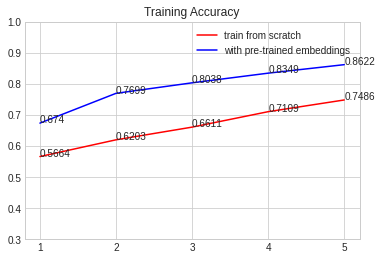

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

pre_train_a = np.array([0.67402523, 0.76992546, 0.80375573, 0.83486239, 0.86224197])

x = [1,2,3,4,5]
x = np.array(x)
train_a = np.array(train_a)

plt.ylim(0.3, 1)
plt.xticks(np.linspace(0, 6, 6, endpoint=False))
plt.title('Training Accuracy')
plt.plot(x, train_a, color='red', label='train from scratch')
for i,j in zip(x,np.round(train_a, 4)):
    plt.annotate(str(j),xy=(i,j))

plt.plot(x, pre_train_a, color='blue', label='with pre-trained embeddings')
for i,j in zip(x,np.round(pre_train_a, 4)):
    plt.annotate(str(j),xy=(i,j))

plt.legend()

plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/NLP/train_acc_compare.png')

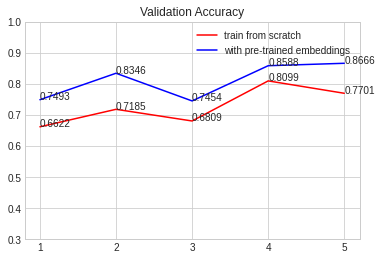

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

pre_val_a = np.array([0.74932651, 0.83459052, 0.74542026, 0.8588362, 0.8666487 ])

x = [1,2,3,4,5]
x = np.array(x)
val_a = np.array(val_a)

plt.ylim(0.3, 1)
plt.xticks(np.linspace(0, 6, 6, endpoint=False))
plt.title('Validation Accuracy')
plt.plot(x, val_a, color='red', label='train from scratch')
for i,j in zip(x,np.round(val_a, 4)):
    plt.annotate(str(j),xy=(i,j))

plt.plot(x, pre_val_a, color='blue', label='with pre-trained embeddings')
for i,j in zip(x,np.round(pre_val_a, 4)):
    plt.annotate(str(j),xy=(i,j))

plt.legend()

plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/NLP/validation_acc_compare.png')

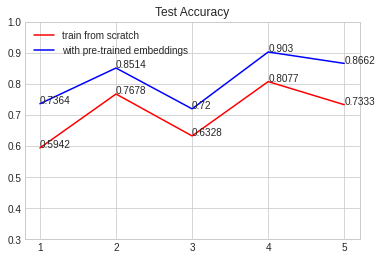

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

pre_test_a = np.array([0.73639548, 0.85142781, 0.71996228, 0.90301724, 0.86624461])

x = [1,2,3,4,5]
x = np.array(x)
val_a = np.array(val_a)

plt.ylim(0.3, 1)
plt.xticks(np.linspace(0, 6, 6, endpoint=False))
plt.title('Test Accuracy')
plt.plot(x, test_a, color='red', label='train from scratch')
for i,j in zip(x,np.round(test_a, 4)):
    plt.annotate(str(j),xy=(i,j))

plt.plot(x, pre_test_a, color='blue', label='with pre-trained embeddings')
for i,j in zip(x,np.round(pre_test_a, 4)):
    plt.annotate(str(j),xy=(i,j))

plt.legend()

plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/NLP/test_acc_compare.png')